In [1]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipeline, StableDiffusionDepth2ImgPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"
device

c:\Users\TYC\Desktop\python code\hugging face\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [2]:
def download_image(url):
    
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

In [3]:
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

img_height = 512
img_width = 512

init_image = download_image(img_url).resize((img_height, img_width))
mask_image = download_image(mask_url).resize((img_height, img_width))

In [4]:
import numpy as np

#encode image
init_image_tensor = torch.from_numpy(np.array(init_image).transpose(2, 0, 1)).float() / 255.0 #[0, 1]
init_image_tensor = 2.0 * init_image_tensor - 1.0 # [-1, 1]
init_image_tensor = init_image_tensor.unsqueeze(0).to(device)


torch.Size([64, 64])

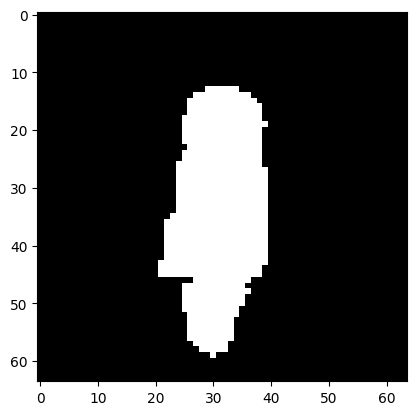

In [5]:
#inpainting

#resize mask image
mask_image_latent_size = mask_image.resize((64, 64))
mask_image_latent_size = torch.tensor((np.array(mask_image_latent_size)[...,0] > 5).astype(np.float32)) #grab everything from the first channel which everything brighter than 5 as the mask

plt.imshow(mask_image_latent_size.numpy(), cmap="gray")

mask_image_latent_size = mask_image_latent_size.to(device)
mask_image_latent_size.shape

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  8.28it/s]
c:\Users\TYC\Desktop\python code\hugging face\.venv\Lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:313: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)


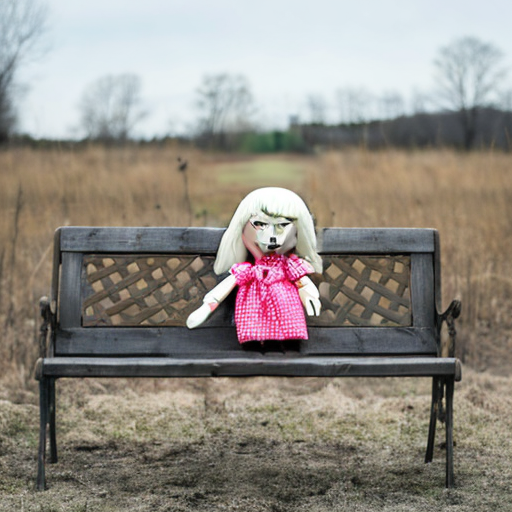

In [7]:
#load pipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)

#encode
with torch.no_grad():
    init_image_latents = pipe.vae.encode(init_image_tensor).latent_dist.sample() * pipe.vae.config.scaling_factor

#denoising loop
guidance_scale = 8
num_inference_steps = 20
prompt = "A small creepy doll, broken, cursed, sitting on a park bench"
negative_prompt = "zoomed in, blurry, oversaturated, warped, lively, blessed, holy"
generator = torch.Generator(device=device).manual_seed(42)

text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)

#random starting point
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma

pipe.scheduler.set_timesteps(num_inference_steps, device=device)

for i, t in enumerate(pipe.scheduler.timesteps):

    #expand
    latent_model_input = torch.cat([latents] * 2)

    #scale
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    #predict
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states = text_embeddings).sample

    #guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents, return_dict=False)[0]

    #inpainting
    if i < len(pipe.scheduler.timesteps) - 1:

        noise = torch.randn(init_image_latents.shape, generator=generator, device=device, dtype=torch.float32) 
        background = pipe.scheduler.add_noise(
            init_image_latents, noise, torch.tensor([pipe.scheduler.timesteps[i + 1]])
        )

        latents = latents * mask_image_latent_size #white in the areas
        background = background * (1 - mask_image_latent_size) #black in the areas

        #combine generated and original image latents based on mask
        latents += background

#decode
   
latents_norm = latents / pipe.vae.config.scaling_factor

with torch.no_grad():
    inpainted_image = pipe.vae.decode(latents_norm).sample

inpainted_image = (inpainted_image / 2 + 0.5).clamp(0, 1).squeeze()
inpainted_image = (inpainted_image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
inpainted_image = Image.fromarray(inpainted_image)

inpainted_image

In [8]:
#inpainting by pipeline
pipe = StableDiffusionInpaintPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting")
pipe = pipe.to(device)

c:\Users\TYC\Desktop\python code\hugging face\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\TYC\.cache\huggingface\hub\models--stabilityai--stable-diffusion-2-inpainting. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Loading pipeline components...: 100%|██████████| 6/6 [00:02<00:00,  2.09it/s]

100%|██████████| 50/50 [02:36<00:00,  3.13s/it]


Text(0.5, 1.0, 'Result')

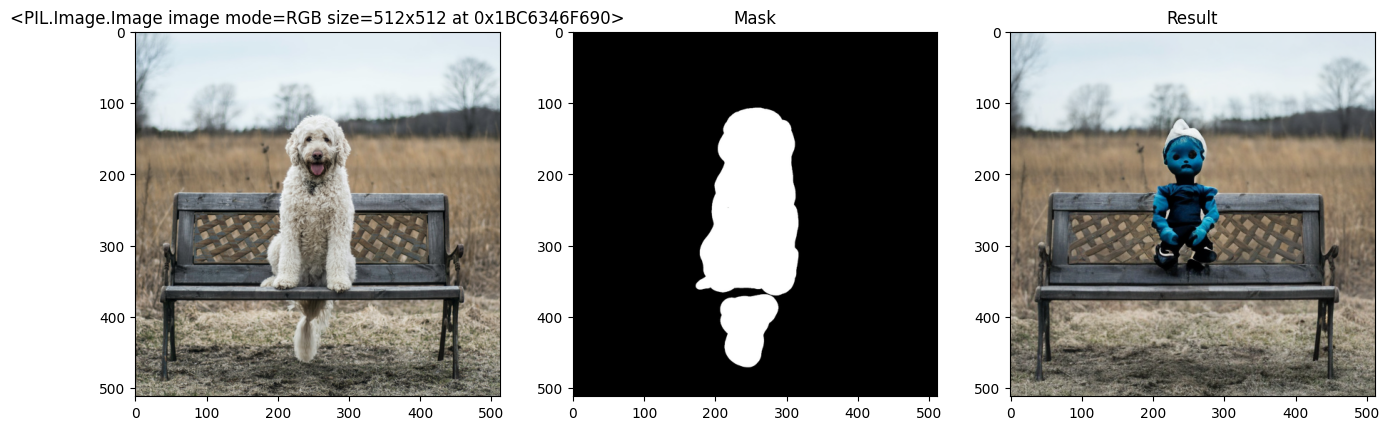

In [9]:
prompt = "A small creepy doll, broken, cursed, sitting on a park bench"
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]

#view
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].imshow(init_image)
axs[0].set_title(init_image)
axs[1].imshow(mask_image)
axs[1].set_title("Mask")
axs[2].imshow(image)
axs[2].set_title("Result")

In [10]:
#depth2image
pipe = StableDiffusionDepth2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-2-depth")
pipe.to(device)

c:\Users\TYC\Desktop\python code\hugging face\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\TYC\.cache\huggingface\hub\models--stabilityai--stable-diffusion-2-depth. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.95it/s]


StableDiffusionDepth2ImgPipeline {
  "_class_name": "StableDiffusionDepth2ImgPipeline",
  "_diffusers_version": "0.34.0",
  "_name_or_path": "stabilityai/stable-diffusion-2-depth",
  "depth_estimator": [
    "transformers",
    "DPTForDepthEstimation"
  ],
  "feature_extractor": [
    "transformers",
    "DPTImageProcessor"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

100%|██████████| 40/40 [03:12<00:00,  4.82s/it]


Text(0.5, 1.0, 'Result')

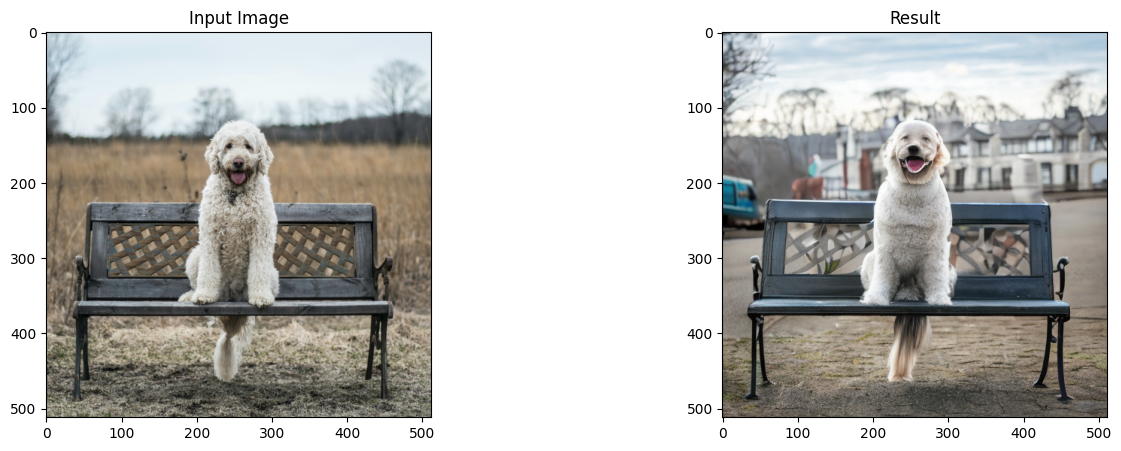

In [13]:
prompt = "A good doggo on a bench"
image = pipe(prompt=prompt, image=init_image).images[0]

#view
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].imshow(init_image)
axs[0].set_title("Input Image")
axs[1].imshow(image)
axs[1].set_title("Result")